# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [10]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-7, 1e-6, 2e-6, 8e-6]
regularization_strengths = [5e3, 1e4, 2e4, 4e4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_iters = 1000
for l_r in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        
        # train
        loss_hist = svm.train(X_train_feats, y_train, l_r, reg, num_iters, verbose=False)
        
        # test
        y_train_pred = svm.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        print('training accuracy with (l_r, reg) = (%e, %e): %f' % (l_r, reg, acc_train, ))

        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        print('validation accuracy with (l_r, reg) = (%e, %e): %f' % (l_r, reg, acc_val, ))
        
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
       
        results[(l_r, reg)] = (acc_train, acc_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training accuracy with (l_r, reg) = (5.000000e-07, 5.000000e+03): 0.406878
validation accuracy with (l_r, reg) = (5.000000e-07, 5.000000e+03): 0.401000
training accuracy with (l_r, reg) = (5.000000e-07, 1.000000e+04): 0.414673
validation accuracy with (l_r, reg) = (5.000000e-07, 1.000000e+04): 0.416000
training accuracy with (l_r, reg) = (5.000000e-07, 2.000000e+04): 0.413490
validation accuracy with (l_r, reg) = (5.000000e-07, 2.000000e+04): 0.422000
training accuracy with (l_r, reg) = (5.000000e-07, 4.000000e+04): 0.409857
validation accuracy with (l_r, reg) = (5.000000e-07, 4.000000e+04): 0.407000
training accuracy with (l_r, reg) = (1.000000e-06, 5.000000e+03): 0.411184
validation accuracy with (l_r, reg) = (1.000000e-06, 5.000000e+03): 0.412000
training accuracy with (l_r, reg) = (1.000000e-06, 1.000000e+04): 0.410918
validation accuracy with (l_r, reg) = (1.000000e-06, 1.000000e+04): 0.410000
training accuracy with (l_r, reg) = (1.000000e-06, 2.000000e+04): 0.408449
validation ac

In [11]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.41


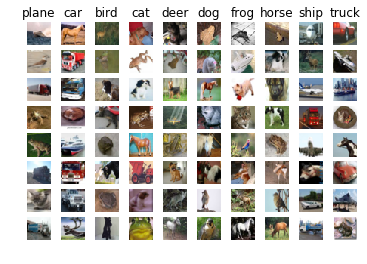

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [16]:
def plot_loss_accuracy_hist(stats, ttl):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history. ' + ttl)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history. ' + ttl)
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 2.301832
iteration 200 / 1000: loss 2.155036
iteration 300 / 1000: loss 1.846856
iteration 400 / 1000: loss 1.802182
iteration 500 / 1000: loss 1.553605
iteration 600 / 1000: loss 1.417423
iteration 700 / 1000: loss 1.587449
iteration 800 / 1000: loss 1.430411
iteration 900 / 1000: loss 1.422924
Validation accuracy:  0.513


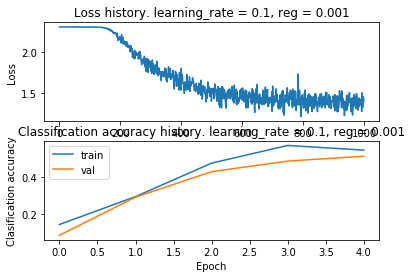

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 2.302453
iteration 200 / 1000: loss 2.197943
iteration 300 / 1000: loss 1.913970
iteration 400 / 1000: loss 1.796902
iteration 500 / 1000: loss 1.723656
iteration 600 / 1000: loss 1.666187
iteration 700 / 1000: loss 1.600670
iteration 800 / 1000: loss 1.535739
iteration 900 / 1000: loss 1.572141
Validation accuracy:  0.491


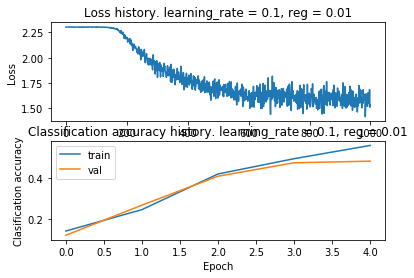

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302667
iteration 100 / 1000: loss 2.302768
iteration 200 / 1000: loss 2.301020
iteration 300 / 1000: loss 2.301312
iteration 400 / 1000: loss 2.280036
iteration 500 / 1000: loss 2.192605
iteration 600 / 1000: loss 2.243608
iteration 700 / 1000: loss 2.205901
iteration 800 / 1000: loss 2.218759
iteration 900 / 1000: loss 2.178866
Validation accuracy:  0.296


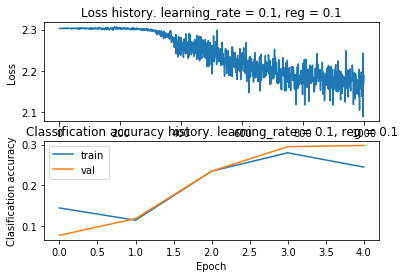

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.303408
iteration 100 / 1000: loss 2.302979
iteration 200 / 1000: loss 2.303109
iteration 300 / 1000: loss 2.303112
iteration 400 / 1000: loss 2.302292
iteration 500 / 1000: loss 2.302856
iteration 600 / 1000: loss 2.303454
iteration 700 / 1000: loss 2.303288
iteration 800 / 1000: loss 2.301876
iteration 900 / 1000: loss 2.302154
Validation accuracy:  0.078


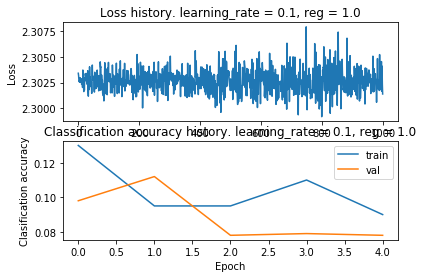

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.310792
iteration 100 / 1000: loss 2.302476
iteration 200 / 1000: loss 2.300428
iteration 300 / 1000: loss 2.301945
iteration 400 / 1000: loss 2.302336
iteration 500 / 1000: loss 2.303652
iteration 600 / 1000: loss 2.301526
iteration 700 / 1000: loss 2.301539
iteration 800 / 1000: loss 2.301627
iteration 900 / 1000: loss 2.303766
Validation accuracy:  0.078


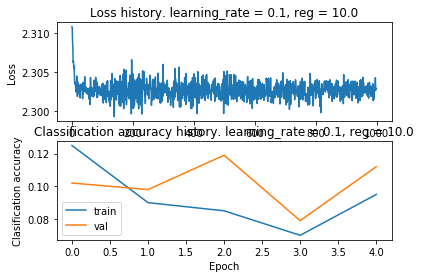

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 2.213961
iteration 200 / 1000: loss 1.733865
iteration 300 / 1000: loss 1.481419
iteration 400 / 1000: loss 1.411461
iteration 500 / 1000: loss 1.331086
iteration 600 / 1000: loss 1.406833
iteration 700 / 1000: loss 1.349273
iteration 800 / 1000: loss 1.274955
iteration 900 / 1000: loss 1.230610
Validation accuracy:  0.531


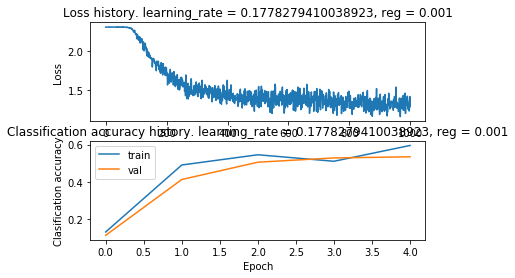

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 2.260594
iteration 200 / 1000: loss 1.834190
iteration 300 / 1000: loss 1.629769
iteration 400 / 1000: loss 1.658665
iteration 500 / 1000: loss 1.448076
iteration 600 / 1000: loss 1.575670
iteration 700 / 1000: loss 1.547359
iteration 800 / 1000: loss 1.662324
iteration 900 / 1000: loss 1.520214
Validation accuracy:  0.515


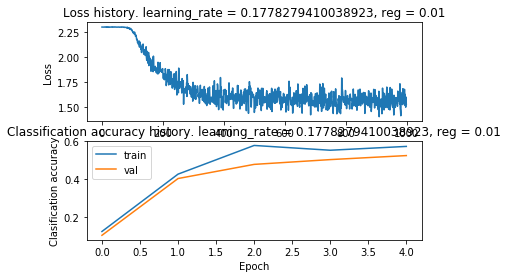

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302667
iteration 100 / 1000: loss 2.302835
iteration 200 / 1000: loss 2.287611
iteration 300 / 1000: loss 2.187236
iteration 400 / 1000: loss 2.199419
iteration 500 / 1000: loss 2.128751
iteration 600 / 1000: loss 2.154859
iteration 700 / 1000: loss 2.145303
iteration 800 / 1000: loss 2.176159
iteration 900 / 1000: loss 2.160272
Validation accuracy:  0.278


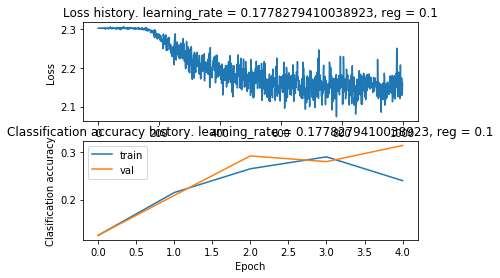

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.303403
iteration 100 / 1000: loss 2.299613
iteration 200 / 1000: loss 2.302650
iteration 300 / 1000: loss 2.301857
iteration 400 / 1000: loss 2.304746
iteration 500 / 1000: loss 2.301745
iteration 600 / 1000: loss 2.303701
iteration 700 / 1000: loss 2.301122
iteration 800 / 1000: loss 2.300877
iteration 900 / 1000: loss 2.306064
Validation accuracy:  0.102


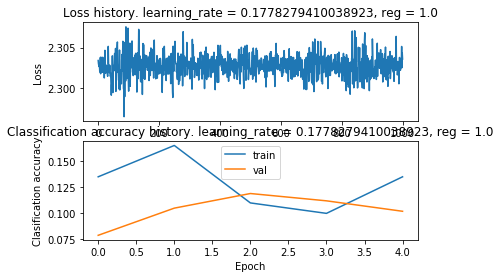

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.310774


C:\EyalBr\Courses Online\CS231n Convolutional Neural Networks for Visual Recognition\Assignments\Assignment 1\assignment1\cs231n\classifiers\neural_net.py:103: RuntimeWarning: divide by zero encountered in log
  losses = -np.log(probs_y)


iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf


C:\EyalBr\Courses Online\CS231n Convolutional Neural Networks for Visual Recognition\Assignments\Assignment 1\assignment1\cs231n\classifiers\neural_net.py:106: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
C:\EyalBr\Courses Online\CS231n Convolutional Neural Networks for Visual Recognition\Assignments\Assignment 1\assignment1\cs231n\classifiers\neural_net.py:98: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1)[:, np.newaxis] # exp norm factor
C:\EyalBr\Courses Online\CS231n Convolutional Neural Networks for Visual Recognition\Assignments\Assignment 1\assignment1\cs231n\classifiers\neural_net.py:98: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1)[:, np.newaxis] # exp norm factor
C:\EyalBr\Courses Online\CS231n Convolutional Neural Networks for Visual Recognition\Assignments\Assignment 1\assignment1\cs231n\classifiers\neural_net.py:131: RuntimeWarning: 

iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


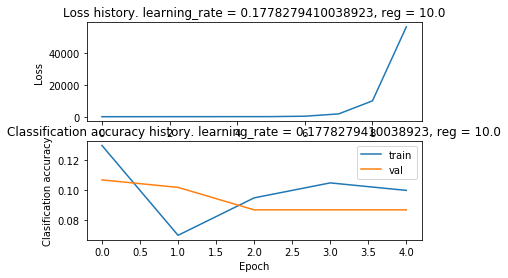

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.802799
iteration 200 / 1000: loss 1.496521
iteration 300 / 1000: loss 1.427212
iteration 400 / 1000: loss 1.459107
iteration 500 / 1000: loss 1.325446
iteration 600 / 1000: loss 1.200826
iteration 700 / 1000: loss 1.307986
iteration 800 / 1000: loss 1.219185
iteration 900 / 1000: loss 1.299125
Validation accuracy:  0.553


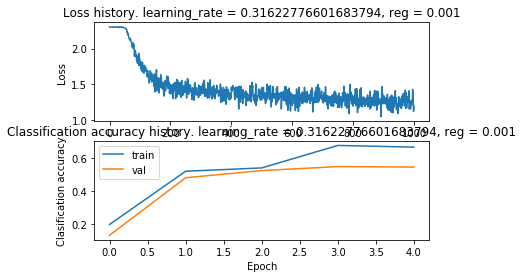

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 1.912524
iteration 200 / 1000: loss 1.648443
iteration 300 / 1000: loss 1.510742
iteration 400 / 1000: loss 1.608304
iteration 500 / 1000: loss 1.575461
iteration 600 / 1000: loss 1.621755
iteration 700 / 1000: loss 1.443226
iteration 800 / 1000: loss 1.607398
iteration 900 / 1000: loss 1.583346
Validation accuracy:  0.506


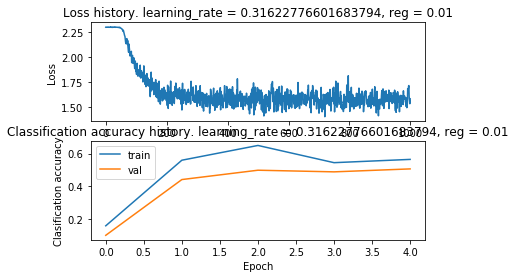

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302667
iteration 100 / 1000: loss 2.296320
iteration 200 / 1000: loss 2.199101
iteration 300 / 1000: loss 2.154742
iteration 400 / 1000: loss 2.157142
iteration 500 / 1000: loss 2.216865
iteration 600 / 1000: loss 2.108133
iteration 700 / 1000: loss 2.136922
iteration 800 / 1000: loss 2.104463
iteration 900 / 1000: loss 2.152937
Validation accuracy:  0.289


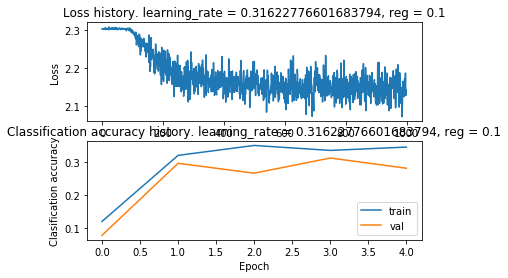

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.303399
iteration 100 / 1000: loss 2.303888
iteration 200 / 1000: loss 2.301326
iteration 300 / 1000: loss 2.300743
iteration 400 / 1000: loss 2.306460
iteration 500 / 1000: loss 2.303440
iteration 600 / 1000: loss 2.302493
iteration 700 / 1000: loss 2.304075
iteration 800 / 1000: loss 2.301634
iteration 900 / 1000: loss 2.303916
Validation accuracy:  0.079


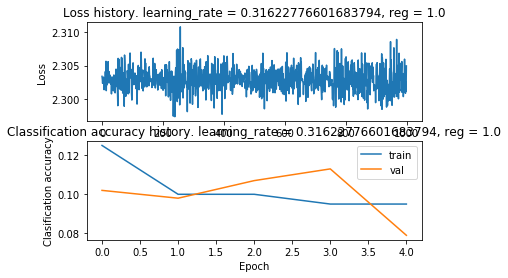

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.310703
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


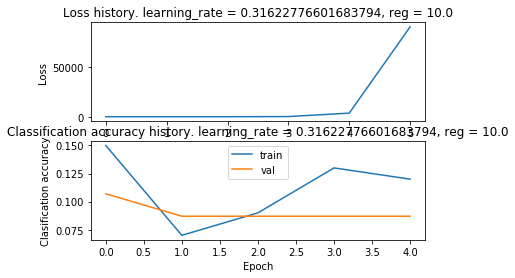

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.516355
iteration 200 / 1000: loss 1.351670
iteration 300 / 1000: loss 1.430034
iteration 400 / 1000: loss 1.402810
iteration 500 / 1000: loss 1.299442
iteration 600 / 1000: loss 1.220575
iteration 700 / 1000: loss 1.268565
iteration 800 / 1000: loss 1.131287
iteration 900 / 1000: loss 1.277745
Validation accuracy:  0.572


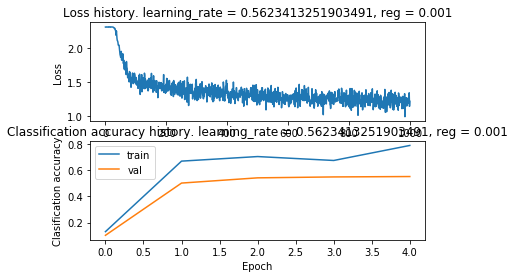

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 1.710407
iteration 200 / 1000: loss 1.632370
iteration 300 / 1000: loss 1.623431
iteration 400 / 1000: loss 1.552278
iteration 500 / 1000: loss 1.546840
iteration 600 / 1000: loss 1.639008
iteration 700 / 1000: loss 1.644295
iteration 800 / 1000: loss 1.609074
iteration 900 / 1000: loss 1.686240
Validation accuracy:  0.489


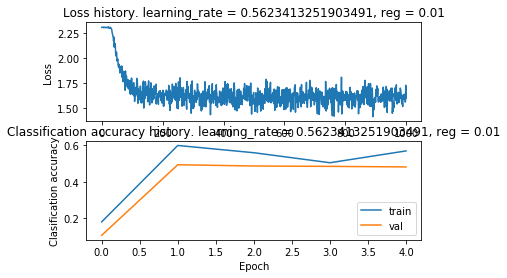

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302666
iteration 100 / 1000: loss 2.228546
iteration 200 / 1000: loss 2.215425
iteration 300 / 1000: loss 2.150898
iteration 400 / 1000: loss 2.145471
iteration 500 / 1000: loss 2.154543
iteration 600 / 1000: loss 2.190011
iteration 700 / 1000: loss 2.157845
iteration 800 / 1000: loss 2.161262
iteration 900 / 1000: loss 2.147039
Validation accuracy:  0.296


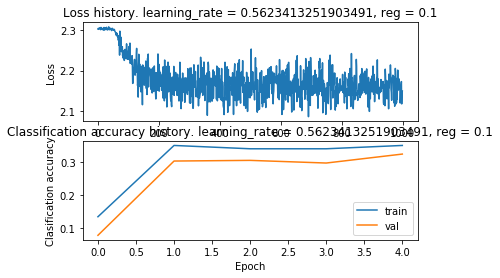

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.303405
iteration 100 / 1000: loss 2.302973
iteration 200 / 1000: loss 2.305343
iteration 300 / 1000: loss 2.304749
iteration 400 / 1000: loss 2.304900
iteration 500 / 1000: loss 2.299276
iteration 600 / 1000: loss 2.302235
iteration 700 / 1000: loss 2.304519
iteration 800 / 1000: loss 2.302608
iteration 900 / 1000: loss 2.302324
Validation accuracy:  0.112


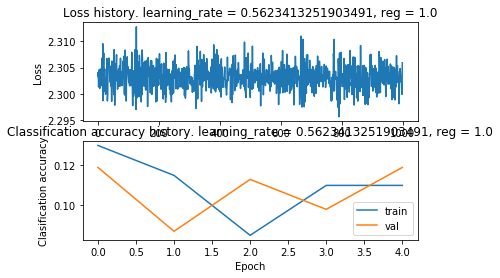

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.310772
iteration 100 / 1000: loss inf


C:\Users\EyalBr84\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


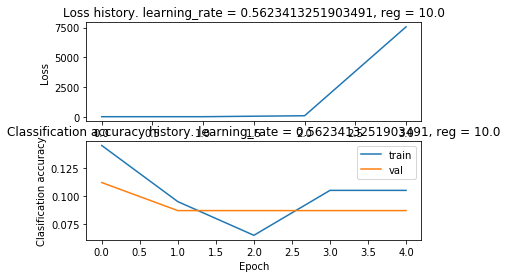

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.542384
iteration 200 / 1000: loss 1.297065
iteration 300 / 1000: loss 1.410142
iteration 400 / 1000: loss 1.343364
iteration 500 / 1000: loss 1.286157
iteration 600 / 1000: loss 1.266146
iteration 700 / 1000: loss 1.391344
iteration 800 / 1000: loss 1.299290
iteration 900 / 1000: loss 1.259976
Validation accuracy:  0.561


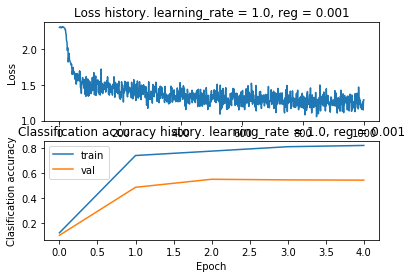

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 1.683424
iteration 200 / 1000: loss 1.644914
iteration 300 / 1000: loss 1.620252
iteration 400 / 1000: loss 1.504443
iteration 500 / 1000: loss 1.785150
iteration 600 / 1000: loss 1.702080
iteration 700 / 1000: loss 1.648721
iteration 800 / 1000: loss 1.639695
iteration 900 / 1000: loss 1.765989
Validation accuracy:  0.516


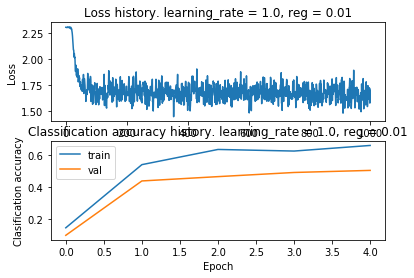

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.302667
iteration 100 / 1000: loss 2.190868
iteration 200 / 1000: loss 2.176003
iteration 300 / 1000: loss 2.153618
iteration 400 / 1000: loss 2.115194
iteration 500 / 1000: loss 2.197375
iteration 600 / 1000: loss 2.197546
iteration 700 / 1000: loss 2.212004
iteration 800 / 1000: loss 2.182216
iteration 900 / 1000: loss 2.190815
Validation accuracy:  0.317


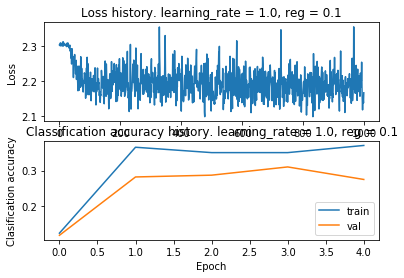

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.303408
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


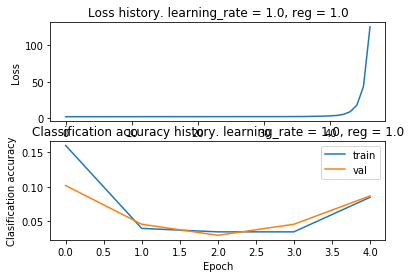

X_train_feats (49000, 154)
iteration 0 / 1000: loss 2.310721
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


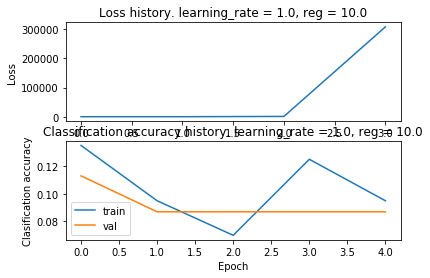

Best net params: acc = 0.572000, learning_rate = 5.623413e-01, reg = 0.001000


In [31]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
best_acc = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = np.logspace(-1, 0, 5)
regs = np.logspace(-3, 1, 5)
best_learning_rate = None
best_reg = None
num_iters = 1000
for learning_rate in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    
        # Train the network
        print('X_train_feats', X_train_feats.shape)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=num_iters, batch_size=200,
            learning_rate=learning_rate, learning_rate_decay=0.95,
            reg=reg, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print('Validation accuracy: ', val_acc)
        ttl = 'learning_rate = ' + str(learning_rate) + ', reg = ' + str(reg)
        plot_loss_accuracy_hist(stats, ttl)
            
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = net
            best_learning_rate = learning_rate
            best_reg = reg
print('Best net params: acc = %f, learning_rate = %e, reg = %f' % (best_acc, best_learning_rate, best_reg))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [30]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.549
